# Google Colab Setup
**Only for users on Google Colab**

In [1]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
#connectDrive()

# Change path
#changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")

## Setup

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime
from zipfile import ZipFile
from urllib.request import urlretrieve

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

## Check library versions & set seed

In [2]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    1.3.2
tensorflow 2.4.1
keras      2.4.0
numpy      1.20.0


In [3]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Check use of GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF, if GPU is available.")

Default GPU Device: /device:GPU:0


# Data Preparation

## MovieLens Dataset 

|MovieLens 20M Dataset||
|:------------|----------|
|ratings     |20,000,263| 
|movies      |27,278| 
|users       |138,493|

## Load the Data 
 
 ```
 Note: you can just read data directrly 
 pd.read_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")
 ```


In [6]:
# Download and read into Pandas DataFrame
current_path = os.getcwd()
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-20m.zip", \
            current_path+"/datasets/movielens.zip")
ZipFile(current_path+"/datasets/movielens.zip", "r").extractall(current_path+"/datasets/")


In [9]:
current_path = os.getcwd()
ratingDF = pd.read_csv(current_path+"/datasets/ml-20m/ratings.csv")

In [10]:
# Convert fields into appropriate data types 
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: \
                        datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [8]:
# Store DataFrame as pickle for faster loading in the future
ratingDF.to_pickle(current_path+"/datasets/ml-20m/ratingPickle")
ratingDF = pd.read_pickle(current_path+"/datasets/ml-20m/ratingPickle")

In [11]:
# Preview data
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [12]:
ratingDF.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [10]:
# Calculate summary statistics on full dataset
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 138493
Number of unique movies: 26744
Number of total ratings: 20000263
Average number of ratings per user: 144.4


In [14]:
# Reduce size of dataset : 只取rating分數是屬於TOP 1000的電影的資料列,此時資料剩下約12萬多筆

movieIndex = ratingDF.groupby("movieId").count().sort_values(by= 
                "rating",ascending=False)[0:1000].index
#有包含這top 1000 movies的資料
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)] 
ratingDFX2.count() #Count non-NA cells for each column.

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [16]:
ratingDFX2

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000243,138493,53996,4.5,2009-12-03 18:31:44
20000249,138493,59315,4.0,2009-10-17 22:22:18
20000252,138493,60069,4.0,2009-11-13 17:51:27
20000258,138493,68954,4.5,2009-11-13 15:42:00


In [12]:
# 接著在從上述表格, 隨機挑出1000 users, 故資料剩下約9萬筆
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= 
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [13]:
# Reindex movie ID
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [14]:
# Reindex user ID
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


In [15]:
# Generate newly merged DataFrame
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId',
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', 
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


In [16]:
# Save as pickle
pickle_file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratingReducedPickle'])
ratingDFX3.to_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")
ratingDFX3 = pd.read_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")

# Read dataset

In [7]:
# Download and read into Pandas DataFrame
current_path = os.getcwd()
ratingDFX3 = pd.read_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")

In [21]:
ratingDFX3.head(10)

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1
5,49,475,4.5,2013-05-03 02:45:40,6,1
6,49,527,3.5,2013-05-03 02:49:22,7,1
7,49,593,4.0,2013-05-03 02:51:10,8,1
8,49,610,4.0,2013-05-03 02:46:44,9,1
9,49,785,3.5,2013-05-03 02:44:34,10,1


In [22]:
np.sum(ratingDFX3.isnull(),axis=0)  # or df.isna()

userId        0
movieId       0
rating        0
timestamp     0
newMovieId    0
newUserId     0
dtype: int64

In [23]:
ratingDFX3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90213 entries, 0 to 90212
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   userId      90213 non-null  int32  
 1   movieId     90213 non-null  int32  
 2   rating      90213 non-null  float64
 3   timestamp   90213 non-null  object 
 4   newMovieId  90213 non-null  int64  
 5   newUserId   90213 non-null  int64  
dtypes: float64(1), int32(2), int64(2), object(1)
memory usage: 4.1+ MB


In [24]:
ratingDFX3.describe()
#rating 最小值是 0.5

,userId,movieId,rating,newMovieId,newUserId
count,90213.000000,90213.000000,90213.000000,90213.000000,90213.000000
mean,69174.188787,4344.580870,3.625896,400.148748,490.860408
std,40122.438358,11066.728397,1.025440,280.464924,283.210360
min,49.000000,1.000000,0.500000,1.000000,1.000000
25%,33512.000000,553.000000,3.000000,139.000000,249.000000
50%,67793.000000,1380.000000,4.000000,364.000000,482.000000
75%,103394.000000,3072.000000,4.000000,615.000000,725.000000
max,138172.000000,81845.000000,5.000000,1000.000000,1000.000000


In [25]:
# Calculate summary statistics on reduced dataset
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 1000
Number of unique movies: 1000
Number of total ratings: 90213
Average number of ratings per user: 90.2


In [26]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)
X_valid, X_test = train_test_split(X_test,     test_size=0.50, \
                                   shuffle=True, random_state=2018)

In [27]:
# Confirm size of train, validation, and test datasets
for (l,x) in [('train',X_train),('validation',X_valid),('test',X_test)]:
    print(f'Size of {l} set: {len(x)}')

Size of train set: 81191
Size of validation set: 4511
Size of test set: 4511


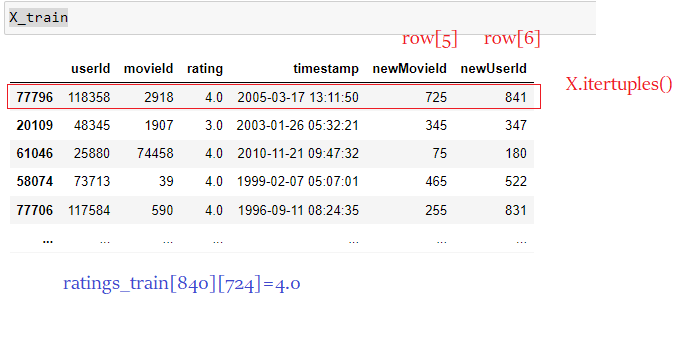

In [28]:
# Generate ratings matrix for train, validation and test
ratings_train = np.zeros((n_users, n_movies))
ratings_valid = np.zeros((n_users, n_movies))
ratings_test  = np.zeros((n_users, n_movies))
for (X,ratings) in [(X_train,ratings_train),(X_valid,ratings_valid),(X_test,ratings_test)]:
    for row in X.itertuples(): #itertuples:pandas datqframe中取出列
        ratings[row[6]-1, row[5]-1] = row[3]

In [29]:
X_train

,userId,movieId,rating,timestamp,newMovieId,newUserId
77796,118358,2918,4.0,2005-03-17 13:11:50,725,841
20109,48345,1907,3.0,2003-01-26 05:32:21,345,347
61046,25880,74458,4.0,2010-11-21 09:47:32,75,180
58074,73713,39,4.0,1999-02-07 05:07:01,465,522
77706,117584,590,4.0,1996-09-11 08:24:35,255,831
...,...,...,...,...,...,...
10388,27131,52,5.0,2000-07-03 18:02:48,634,195
40092,108946,2028,4.0,2001-01-31 05:48:49,57,769
84745,32312,5299,4.0,2005-03-27 06:42:32,380,243
80098,93974,508,5.0,2003-01-20 07:06:12,39,654


In [36]:
ratings_train[840][724]

4.0

In [45]:
ratings_train[0][:50]

array([5. , 3.5, 0. , 5. , 3. , 4.5, 3.5, 4. , 4. , 3.5, 2.5, 0. , 3. ,
       4. , 4. , 4. , 3. , 4. , 4.5, 3. , 3.5, 4. , 3.5, 4. , 4. , 3.5,
       4. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [37]:
ratings_train.shape, ratings_valid.shape, ratings_test.shape

((1000, 1000), (1000, 1000), (1000, 1000))

In [38]:
# Calculate the sparsity of the train, validation & test rating matrices
def calc_sparsity(label, ratings):
    sparsity = float(len(ratings.nonzero()[0]))
    sparsity /= (ratings.shape[0] * ratings.shape[1])
    sparsity *= 100
    print('{:s} Sparsity: {:4.2f}%'.format(label, sparsity))

In [39]:
for (lbl, rtg) in [('Train',ratings_train),('Validation',ratings_valid),('Test', ratings_test)]:
    calc_sparsity(lbl,rtg)

Train Sparsity: 8.12%
Validation Sparsity: 0.45%
Test Sparsity: 0.45%


# Perform Baseline Experiments 

In [131]:
ratings_valid.shape

(1000, 1000)

In [132]:
ratings_valid[0]

array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [133]:
ratings_valid.nonzero()

(array([  0,   1,   1, ..., 998, 998, 998], dtype=int64),
 array([  2,  35,  36, ..., 966, 968, 985], dtype=int64))

In [134]:
# Flatten the sprace matrix with the rations for the validation set. This will be the vector of actual ratings
#numpy.nonzero():returns two arrays, 
#The first array represents the row indices where the non-zero elements are found.
#The second array represents the column indices where the non-zero elements are found.
actual_valid = ratings_valid[ratings_valid.nonzero()].flatten()

In [135]:
actual_valid

array([3., 1., 3., ..., 3., 3., 4.])

In [136]:
len(actual_valid)

4511

## Experiment One 
### Assign naive 3.5 rating and calculate baseline MSE

### 比較的基準是你對於電影評價的預測評價和他實際上對此電影的評價    

In [137]:
pred_valid = np.zeros((len(actual_valid),1))


In [138]:
pred_valid.shape

(4511, 1)

In [139]:
pred_valid

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [140]:
pred_valid[pred_valid==0]=3.5

In [141]:
pred_valid

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

In [121]:
naive_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using naive prediction: {round(naive_prediction,2)}')

Mean squared error using naive prediction: 1.06


## Experiment Two
## Predict a user's rating based on user's average rating for all other movies
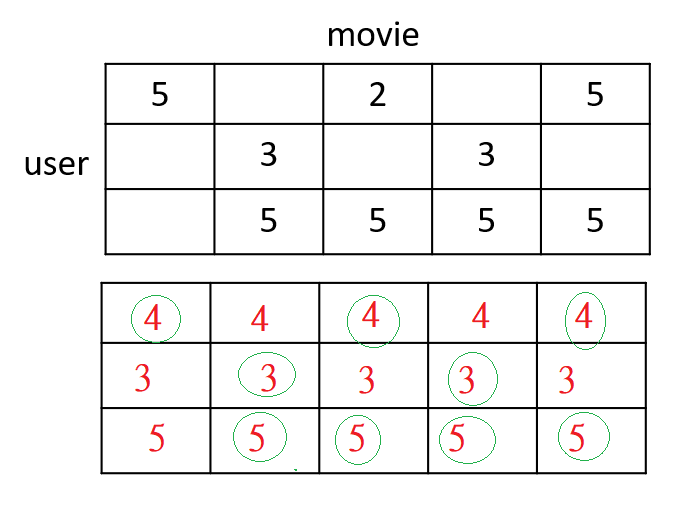

In [153]:
ratings_train.shape

(1000, 1000)

In [154]:
ratings_train

array([[5. , 3.5, 0. , ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 3. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 4. , 0. , ..., 0. , 0. , 0. ],
       [4. , 2. , 1.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [159]:
ratings_valid_pred = np.zeros((n_users, n_movies))
print(ratings_valid_pred.shape)

(1000, 1000)


In [160]:
ratings_valid_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [162]:

i = 0
for row in ratings_train:  #ratings_valid_pred 每個人對其沒有看過的電影都設成其對電影的平均評價
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    #ratings_valid_pred[i][ratings_valid[i]==0] = np.mean(row[row>0])
    i += 1

#比較的基準是你對於電影評價的預測評價和他實際上對此電影的評價    
#故只取ratings_valid_pred中屬於ratings_valid有評價的電影出來和actual_valid做比較,就知道預測準不準確
pred_valid = ratings_valid_pred[ratings_valid.nonzero()].flatten()



user_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using user average: {round(user_average,3)}')

Mean squared error using user average: 0.909


In [96]:
ratings_valid_pred

array([[4.32291667, 3.45108696, 3.37      , ..., 0.        , 4.04166667,
        3.77777778],
       [4.32291667, 3.45108696, 3.37      , ..., 4.13235294, 4.04166667,
        3.77777778],
       [0.        , 3.45108696, 3.37      , ..., 4.13235294, 4.04166667,
        3.77777778],
       ...,
       [4.32291667, 3.45108696, 3.37      , ..., 4.13235294, 4.04166667,
        3.77777778],
       [4.32291667, 3.45108696, 3.37      , ..., 4.13235294, 4.04166667,
        3.77777778],
       [4.32291667, 3.45108696, 3.37      , ..., 4.13235294, 4.04166667,
        3.77777778]])

## Experiment Three
### Predict a user's rating for a movie based on the average rating other users have given that movie 


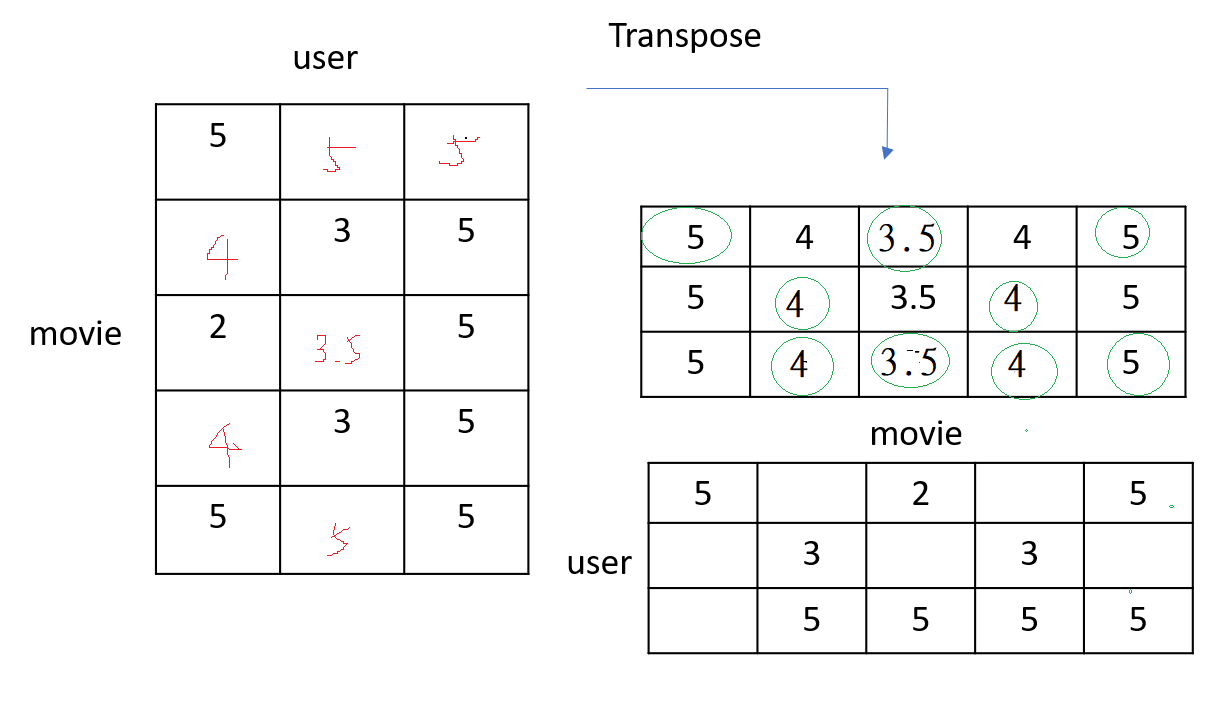


In [147]:
ratings_valid_pred = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    i += 1

ratings_valid_pred = ratings_valid_pred.T
pred_valid = ratings_valid_pred[ratings_valid.nonzero()].flatten()
movie_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using movie average: {round(movie_average,3)}')

Mean squared error using movie average: 0.914


# Matrix Factorization 

## Experiment Four - Recommender System using Matrix Factorization
### One Latent Factor

In [29]:
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [30]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 14s 5ms/step - loss: 13.9934 - val_loss: 11.5405
Epoch 2/100
2538/2538 [==============================] - 11s 4ms/step - loss: 10.1563 - val_loss: 6.3019
Epoch 3/100
2538/2538 [==============================] - 11s 4ms/step - loss: 5.2883 - val_loss: 3.2721
Epoch 4/100
2538/2538 [==============================] - 11s 4ms/step - loss: 2.8135 - val_loss: 2.0300
Epoch 5/100
2538/2538 [==============================] - 11s 4ms/step - loss: 1.7795 - val_loss: 1.4352
Epoch 6/100
2538/2538 [==============================] - 11s 4ms/step - loss: 1.2735 - val_loss: 1.1348
Epoch 7/100
2538/2538 [==============================] - 11s 4ms/step - loss: 1.0074 - val_loss: 0.9787
Epoch 8/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.8723 - val_loss: 0.8945
Epoch 9/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.8069 - val_loss: 0.8489
Epoch 10/100
2538/2538 [==============================] - 11s

2538/2538 [==============================] - 11s 4ms/step - loss: 0.7243 - val_loss: 0.7970
Epoch 80/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.7268 - val_loss: 0.7982
Epoch 81/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.7229 - val_loss: 0.7977
Epoch 82/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.7199 - val_loss: 0.7983
Epoch 83/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.7225 - val_loss: 0.7980
Epoch 84/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.7205 - val_loss: 0.7972
Epoch 85/100
2538/2538 [==============================] - 11s 4ms/step - loss: 0.7290 - val_loss: 0.7983
Epoch 86/100
2538/2538 [==============================] - 12s 5ms/step - loss: 0.7157 - val_loss: 0.7983
Epoch 87/100
2538/2538 [==============================] - 11s 5ms/step - loss: 0.7242 - val_loss: 0.7996
Epoch 88/100
2538/2538 [==============================] - 11s 4ms/st

Minimum MSE: 0.794


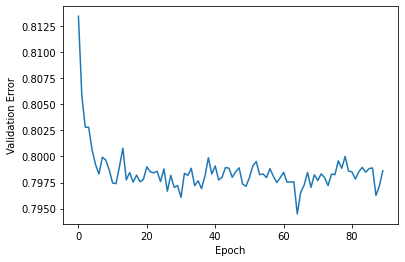

In [31]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

## Experiment Five - Recommender System using Matrix Factorization
### Three Latent Factor

In [32]:
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(10e-7), 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(10e-7), 
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [33]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 14s 5ms/step - loss: 13.5801 - val_loss: 7.5189
Epoch 2/100
2538/2538 [==============================] - 14s 5ms/step - loss: 5.6151 - val_loss: 2.4933
Epoch 3/100
2538/2538 [==============================] - 14s 5ms/step - loss: 2.0465 - val_loss: 1.3535
Epoch 4/100
2538/2538 [==============================] - 13s 5ms/step - loss: 1.1592 - val_loss: 0.9971
Epoch 5/100
2538/2538 [==============================] - 14s 5ms/step - loss: 0.8827 - val_loss: 0.8752
Epoch 6/100
2538/2538 [==============================] - 14s 6ms/step - loss: 0.7903 - val_loss: 0.8313
Epoch 7/100
2538/2538 [==============================] - 14s 6ms/step - loss: 0.7594 - val_loss: 0.8169
Epoch 8/100
2538/2538 [==============================] - 14s 6ms/step - loss: 0.7465 - val_loss: 0.8108
Epoch 9/100
2538/2538 [==============================] - 14s 5ms/step - loss: 0.7445 - val_loss: 0.8053
Epoch 10/100
2538/2538 [==============================] - 14s 5

2538/2538 [==============================] - 14s 5ms/step - loss: 0.6231 - val_loss: 0.7819
Epoch 80/100
2538/2538 [==============================] - 13s 5ms/step - loss: 0.6244 - val_loss: 0.7832
Epoch 81/100
2538/2538 [==============================] - 14s 5ms/step - loss: 0.6216 - val_loss: 0.7814
Epoch 82/100
2538/2538 [==============================] - 14s 5ms/step - loss: 0.6171 - val_loss: 0.7832
Epoch 83/100
2538/2538 [==============================] - 13s 5ms/step - loss: 0.6180 - val_loss: 0.7817
Epoch 84/100
2538/2538 [==============================] - 13s 5ms/step - loss: 0.6185 - val_loss: 0.7806
Epoch 85/100
2538/2538 [==============================] - 14s 5ms/step - loss: 0.6229 - val_loss: 0.7820
Epoch 86/100
2538/2538 [==============================] - 14s 5ms/step - loss: 0.6146 - val_loss: 0.7810
Epoch 87/100
2538/2538 [==============================] - 13s 5ms/step - loss: 0.6216 - val_loss: 0.7848
Epoch 88/100
2538/2538 [==============================] - 13s 5ms/st

Minimum MSE: 0.777


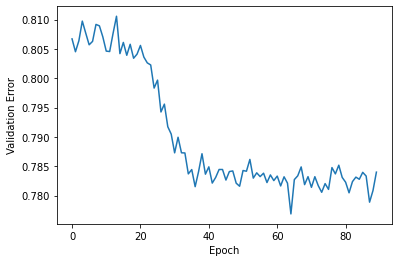

In [34]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

# Conclusion

In [ ]:
import datetime as dt
print("Completed: ", dt.datetime.now())